In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
import torch
from torch import nn
from pyro import distributions as dist

In [4]:
import pyro
import os
from runtimes.pyro.dppl import PyroModel

In [5]:
import torch.utils.data.dataloader as dataloader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

In [6]:
plt.style.use('seaborn-white')

In [7]:
with open('test/integration/dppl/good/vae.stan', 'r') as source:
    print(source.read())

networks {
  real[,] decoder(real[] x);
  real[,] encoder(int[,] x);
}
data {
    int nz;
    int<lower=0, upper=1> x[28, 28];
}
parameters {
    real z[nz];
}
model {
  real mu[28, 28];
  z ~ normal(0, 1);
  mu = decoder(z);
  for (i in 1:28)
    x[i] ~ bernoulli(mu[i]);
}
guide {
  real encoded[2, nz] = encoder(x);
  real mu_z[nz] = encoded[1];
  real sigma_z[nz] = encoded[2];
  z ~ normal(mu_z, sigma_z);
}


In [8]:
batch_size, nx, nh, nz = 256, 28 * 28, 1024, 4

In [9]:
def loadData():
    train = MNIST(os.environ.get("DATA_DIR", '.') + "/data", train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),  # ToTensor does min-max normalization.
    ]), )

    test = MNIST(os.environ.get("DATA_DIR", '.') + "/data", train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),  # ToTensor does min-max normalization.
    ]), )

    dataloader_args = dict(shuffle=True, batch_size=batch_size,
                           num_workers=1, pin_memory=False)
    train_loader = dataloader.DataLoader(train, **dataloader_args)
    test_loader = dataloader.DataLoader(test, **dataloader_args)
    return train_loader, test_loader

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.lh = nn.Linear(nz, nh)
        self.lx = nn.Linear(nh, nx)

    def forward(self, z):
        hidden = torch.relu(self.lh(z))
        mu = self.lx(hidden)
        return torch.sigmoid(mu.view(-1, 1, 28, 28))

# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.lh = torch.nn.Linear(nx, nh)
        self.lz_mu = torch.nn.Linear(nh, nz)
        self.lz_sigma = torch.nn.Linear(nh, nz)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.view((-1, nx))
        hidden = torch.relu(self.lh(x))
        z_mu = self.lz_mu(hidden)
        z_sigma = self.softplus(self.lz_sigma(hidden))
        return z_mu, z_sigma

In [11]:
train_loader, test_loader = loadData()

In [12]:
encoder = Encoder()
decoder = Decoder()

In [13]:
pyro.clear_param_store()

In [14]:
model = PyroModel('test/integration/dppl/good/vae.stan')
svi = model.svi(params = {'lr' : 0.01})

In [15]:
for epoch in tqdm(range(4), desc='epoch'):  # loop over the dataset multiple times
    running_loss = 0.0
    t = tqdm(enumerate(train_loader, 0), desc='mini_batch')
    for j, (imgs, _) in t:
        # calculate the loss and take a gradient step
        loss = svi.step(nz=nz, x=imgs, decoder=decoder, encoder=encoder)
        t.set_postfix(loss = loss)

In [16]:
z_loc, z_scale = encoder(imgs)
decoded = decoder(dist.Normal(z_loc, z_scale).sample())

(-0.5, 27.5, 27.5, -0.5)

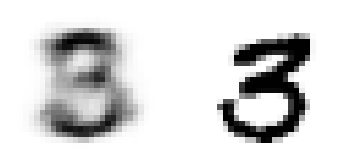

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(decoded[12].data.squeeze().numpy())
ax2.imshow(imgs[12].squeeze().numpy())
ax1.axis('off')
ax2.axis('off')

In [18]:
sample = dist.Bernoulli(decoded[23]).sample()

(-0.5, 27.5, 27.5, -0.5)

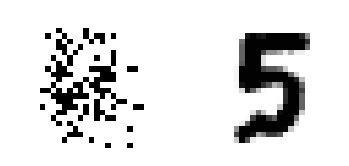

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sample.data.squeeze().numpy())
ax2.imshow(imgs[23].squeeze().numpy())
ax1.axis('off')
ax2.axis('off')